In [3]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

#### Sample 데이터셋 생성 

In [4]:
floatX = theano.config.floatX

In [5]:
x,y = make_moons(noise=0.15, n_samples = 1000, random_state = 50120057)
x = scale(x)
x = x.astype(floatX)
y = y.astype(floatX)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size =0.5)

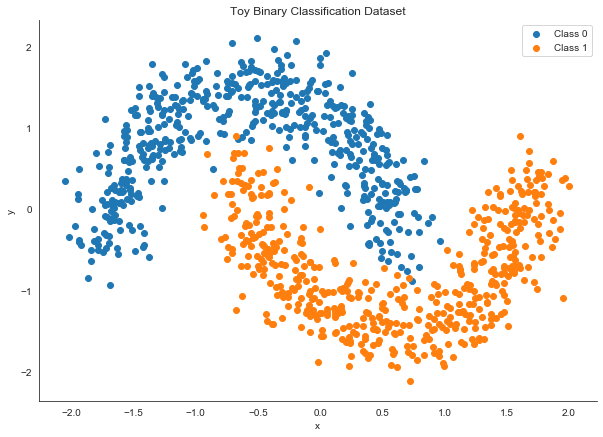

In [6]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x[y==0,0],x[y==0,1], label = 'Class 0', color = 'C0')
ax.scatter(x[y==1,0],x[y==1,1], label = 'Class 1', color = 'C1')
sns.despine()
ax.legend()
ax.set(xlabel = 'x', ylabel = 'y', title = 'Toy Binary Classification Dataset');

- PyMC3은 theano 기반으로 동작
- PyMC3에서는 with 구문으로 모델 정의
- Hidden Layer가 2층이며 각 Layer에서는 10개의 Neuron이 존재하는 경우에 대한 모델을 생성

In [50]:
def construct_nn(ann_input, ann_output) :
    n_hidden_1 = 10; n_hidden_2 = 8
    
    # Initialize random weights between each Layer consider these as prior
    init_1   = np.random.randn(x.shape[1], n_hidden_1).astype(floatX)
    init_2   = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2).astype(floatX)
    
   
    with pm.Model() as neural_network :
        
        # Weights from input to hidden_layer 1
        weights_in_h1 = pm.Normal('w_in_1', 0, sd = 1
                                  , shape = (x.shape[1], n_hidden_1)
                                  , testval = init_1)
        
        # Weights from hidden_layer 1 to hidden_layer 2
        weights_h1_h2 = pm.Normal('w_1_2', 0, sd = 1
                                  , shape = (n_hidden_1, n_hidden_2)
                                  , testval = init_2)
        
        # Weights from hidden_layer 2 to output
        weights_h2_op = pm.Normal('w_2_out', 0, sd =1
                                  , shape = (n_hidden_2,)
                                  , testval = init_out)
        
        # Construct Neural Network using tanh activation function
        
        act_1      = pm.math.tanh(pm.math.dot(ann_input, weights_in_h1))
        act_2      = pm.math.tanh(pm.math.dot(act_1, weights_h1_h2))
        act_output = pm.math.sigmoid(pm.math.dot(act_2, weights_h2_op))
        
        # Binary Classification via Bernoulli-likelihood
        
        output = pm.Bernoulli('out', act_output, observed = ann_output, total_size = y_tr.shape[0]) 
        
    return neural_network        

In [51]:
ann_input = theano.shared(x_tr)
ann_ouput = theano.shared(y_tr)
neural_network = construct_nn(ann_input, ann_ouput)

In [52]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

- Variational Inference 활용한 weight 추정
- Objective Function이 iteration 횟수에 따라 최적화됨을 trace plot을 통해 확인 가능

In [55]:
with neural_network :
    inference = pm.ADVI()
    approx = pm.fit(n = 30000, method = inference)

Finished [100%]: Average Loss = 184.03


- ELBO에 대한 trace plot을 그려보니 약 10,000회 정도부터는 수렴하는 것으로 판단할 수 있음

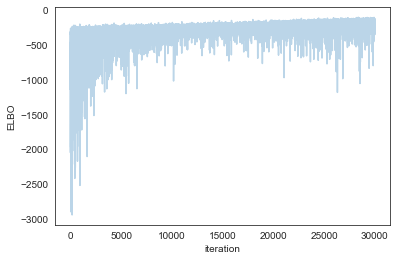

In [56]:
plt.plot(-inference.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

- Variational Inference 로 근사한 posterior 분포로부터 Sample 생성

In [57]:
trace = approx.sample(draws=5000)

- 모델에 대한 학습이 이루어졌으니, posterior predictive distribution에 대한 예측을 수행
- sample_posterior_predictive 함수는 posterior distribution을 활용하여 새로운 데이터에 대한 예측을 수행
- 함수 안에 넣어주는 samples 는 반복 시행의 횟수로 간주, weight 값에 대한 sampling을 진행하기 때문에 여러차례 시도하여 평균값을 취해야 함

In [58]:
# Replace arrays our NN references with the test data
ann_input.set_value(x_ts)
ann_output.set_value(y_ts)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=5000, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

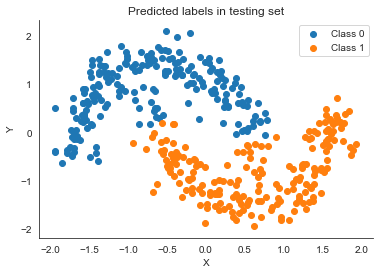

In [67]:
fig, ax = plt.subplots()
ax.scatter(x_ts[pred==0, 0], x_ts[pred==0, 1], label = 'Class 0', color = 'C0')
ax.scatter(x_ts[pred==1, 0], x_ts[pred==1, 1], label = 'Class 1', color = 'C1')
sns.despine()
ax.legend()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [60]:
print('Accuracy = {}%'.format(round((y_ts == pred).mean() * 100),3))

Accuracy = 94%


##### input 값이 가질 수 있는 범위에서 class prediction probability를 확인할 필요가 있음
- 첫번째 contour plot은 Class를 분류하는 Probability에 대한 정보를 출력
- 두번재 contour plot은 Class 분류에 대한 Uncertainty를 출력

In [61]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [62]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=5000, progressbar=False)

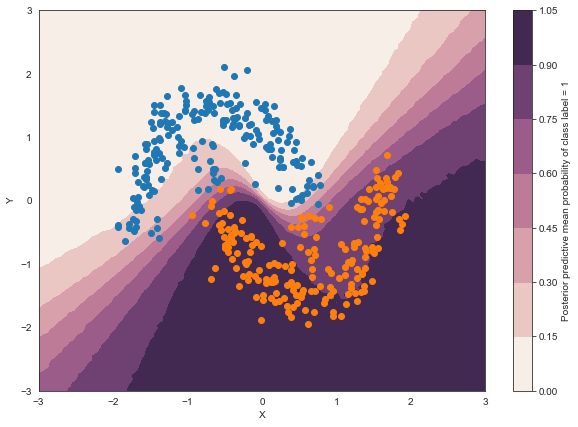

In [91]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 7))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(x_ts[pred==0,0], x_ts[pred==0,1], label = 'Class 0', color = 'C0')
ax.scatter(x_ts[pred==1,0], x_ts[pred==1,1], label = 'Class 1', color = 'C1')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');

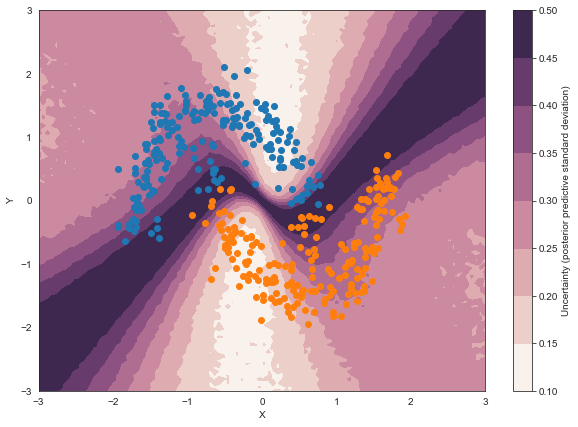

In [93]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 7))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(x_ts[pred==0,0], x_ts[pred==0,1], label = 'Class 0', color = 'C0')
ax.scatter(x_ts[pred==1,0], x_ts[pred==1,1], label = 'Class 1', color = 'C1')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');